In [1]:
# Modisco
%matplotlib inline

import modisco
import json
import os.path
import pandas as pd
import numpy as np
import h5py
from metrics import Pearson
from collections import OrderedDict, Counter, defaultdict
from keras.utils import to_categorical
from keras.models import load_model
from utils import prepare_data



2023-07-16 19:48:51.748680: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def one_hot_emb(data: pd.DataFrame) -> pd.DataFrame:
    mapping = {
        'A': 0,
        'C': 1,
        'G': 2,
        'T': 3
    }
    one_hot_encode_lam = lambda seq: to_categorical([mapping[x] for x in seq])
    return data.apply(one_hot_encode_lam)

In [3]:
train_data, valid_data, test_data = prepare_data()

max_seq_len = train_data['seq'].apply(lambda x: len(x)).max()

max_seq_len = 20788

train_data['length'] = train_data.seq.str.len()

train_data = train_data[train_data.length <= max_seq_len]

data_one_hot = one_hot_emb(train_data['seq'])
#data_struct = train_data['struct']

#padded_sequences = np.zeros((len(train_data['seq']), max_seq_len, 6), dtype=np.float32)
padded_sequences = np.zeros((len(train_data['seq']), max_seq_len, 4), dtype=np.float32)

indices = np.arange(train_data.shape[0])

for i, idx in enumerate(indices):
    #tmp = data_struct.iloc[idx]
    #padded_mask_struct = np.expand_dims(np.array(tmp != 'nan'), axis=1)
    #tmp[tmp == 'nan'] = -1
    #padded_struct = np.expand_dims(tmp, axis=1).astype('float64')
    seq_data = data_one_hot.iloc[idx]
    #seq_data = np.concatenate([seq_data, padded_mask_struct, padded_struct], axis=1)
    padded_sequences[i, -len(data_one_hot.iloc[idx]):, :] = seq_data

data_one_hot = padded_sequences

In [ ]:
"""
    Integrated Gradients
"""
from motif_search import motif_utilities


model_name = "moitfTest3"

model = load_model(f'model_outputs/{model_name}.keras',compile=False)

seqs_to_explain = data_one_hot[:50]

gradients = motif_utilities.get_gradients(model, seqs_to_explain)

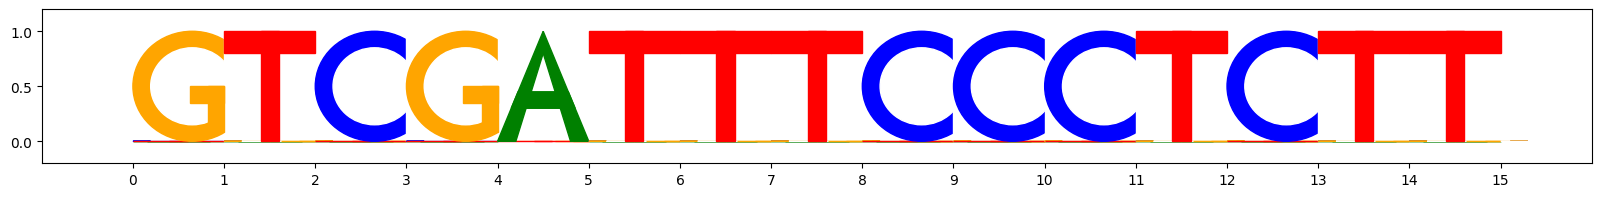

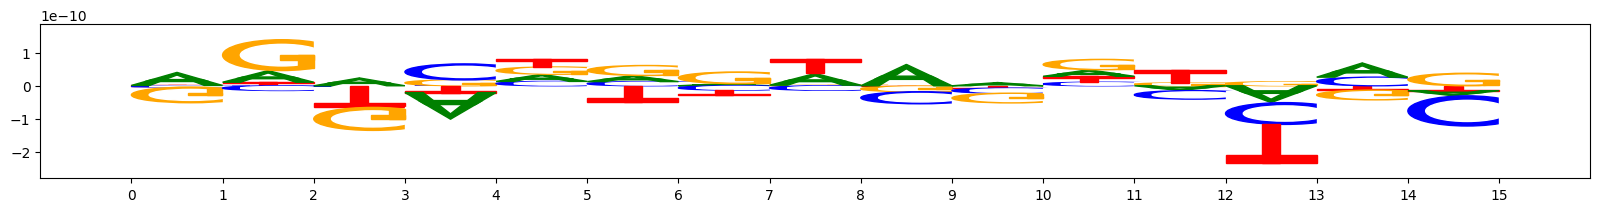

(<Figure size 2000x200 with 1 Axes>, <Axes: >)

In [11]:
print(gradients[6])
# print(data_one_hot)

seq_gradient = gradients[6][::-1]

for i in range(10):
   motif_utilities.plot_weights(seq_gradient[i*50:(i+1)*50], subticks_frequency=10)

In [ ]:
#Uncomment to refresh modules for when tweaking code during development:
from importlib import reload
reload(modisco.util)
reload(modisco.pattern_filterer)
reload(modisco.aggregator)
reload(modisco.core)
reload(modisco.seqlet_embedding.advanced_gapped_kmer)
reload(modisco.affinitymat.transformers)
reload(modisco.affinitymat.core)
reload(modisco.affinitymat)
reload(modisco.cluster.core)
reload(modisco.cluster)
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
reload(modisco.tfmodisco_workflow)
reload(modisco)

scores = OrderedDict()
scores["task0"] = gradients
hypothetical_scores = [] # optional

tasks = {
    "task0": "Identify high-importance windows of the sequences, termed seqlets",
    "task1": "Cluster recurring similar seqlets into motifs",
    "task2": "Scan through importance scores across the genome to call motif instances (AKA hit scoring)"
}

null_per_pos_scores = modisco.coordproducers.LaplaceNullDist(num_to_samp=len(scores))

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    sliding_window_size=11,
                    flank_size=5,
                    target_seqlet_fdr=0.15,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        trim_to_window_size=11,
                        initial_flank_to_add=5,
                        final_flank_to_add=5,
                        final_min_cluster_size=60,
                        n_cores=4)
                )(
                 task_names=["task0"],#, "task1", "task2"],
                 contrib_scores=scores,
                 hypothetical_contribs=scores,
                 one_hot=data_one_hot[:50])